### Import Initial Libraries

In [1]:
!pip install -U -q xgboost
!pip install -U -q openpyxl

In [2]:
# Import initial libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as po
import plotly.graph_objs as go
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline


/var/folders/5v/rs4ws06j7x78q25f1pxgyzd40000gn/T/ipykernel_61067/2722312627.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Load the dataset and view the info

In [34]:
# Load customer data files
training_data = pd.read_excel('./data.xlsx')
training_data.head()
training_data.info()
training_data.columns
training_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28015 entries, 0 to 28014
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CUSTOMER_ID                     28015 non-null  object 
 1   MAIN_OFFER                      28015 non-null  object 
 2   VAS_NAME                        28015 non-null  object 
 3   PACKAGE_NAME                    28015 non-null  object 
 4   VAS_CHARGES                     28015 non-null  float64
 5   DATA_SPEED_Mbps                 28015 non-null  int64  
 6   FUP_FR_Gbps                     28015 non-null  int64  
 7   VOICE_SERVICE                   28015 non-null  object 
 8   IPTV_SERVICE                    28015 non-null  object 
 9   PAYMENT_CHANNEL                 28015 non-null  object 
 10  CUSTOMER_TYPE                   28015 non-null  object 
 11  MARITAL_STATUS                  28015 non-null  object 
 12  AREA_Name                       

(28015, 25)

### Check for Duplicate Primary Key ie. CUSTOMER_ID

In [4]:
# Check if there are any duplicate primary_key values
isDuplicated = training_data['CUSTOMER_ID'].duplicated().any()
print("Are there any duplicated values in the training data?\n",isDuplicated) # It turns out that the primary_key "41654" is duplicated 1000 times


Are there any duplicated values in the training data?
 True


### Preprocessing Function

The `preprocess` function performs several data cleaning and transformation tasks on a DataFrame:

1. **Drop Columns**: Removes columns that are not needed for the analysis, including 'PROVINCE', 'OLT_NAME', 'FAB_NAME', and 'CUSTOMER_NAME'.

2. **Map Customer Status**: Converts the 'CUSTOMER_STATUS' column from categorical ('Stayed', 'Churned') to numerical (1 for 'Stayed', 0 for 'Churned') using a dictionary mapping.

3. **Map OLT Type**: Transforms 'OLT_TYPE' entries from categorical ('ZTE_OLT', 'Huawei_OLT') to binary (1 for 'ZTE_OLT', 0 for 'Huawei_OLT').

4. **Map Yes/No Services**: Converts 'VOICE_SERVICE' and 'IPTV_SERVICE' from 'Yes'/'No' to binary (1 for 'Yes', 0 for 'No').



In [32]:
def preprocess(training_data):
    df=training_data.copy()
    df.drop(columns=['PROVINCE','OLT_NAME','FAB_NAME','CUSTOMER_NAME'], axis=1, inplace=True)
    #Churn Mapping
    churn_mapping={"Stayed":1, "Churned":0}
    df["CUSTOMER_STATUS"]=df["CUSTOMER_STATUS"].map(churn_mapping)
    yes_no_mapping = {"Yes": 1, "No": 0}
    df["VOICE_SERVICE"] = df["VOICE_SERVICE"].map(yes_no_mapping)
    df["IPTV_SERVICE"] = df["IPTV_SERVICE"].map(yes_no_mapping)
    return df

In [35]:
olt_mapping = {original: f"OLT_{chr(65 + i)}" for i, original in enumerate(training_data["OLT_TYPE"].unique())}
onu_mapping = {original: f"ONU_{chr(65 + i)}" for i, original in enumerate(training_data["ONU_TYPE"].unique())}
training_data["OLT_TYPE"] = training_data["OLT_TYPE"].map(olt_mapping)
training_data["ONU_TYPE"] = training_data["ONU_TYPE"].map(onu_mapping)
    # Anonymize ONU_TYPE
processed_data=preprocess(training_data)
processed_data.head()

,CUSTOMER_ID,MAIN_OFFER,VAS_NAME,PACKAGE_NAME,VAS_CHARGES,DATA_SPEED_Mbps,FUP_FR_Gbps,VOICE_SERVICE,IPTV_SERVICE,PAYMENT_CHANNEL,...,MARITAL_STATUS,AREA_Name,OLT_TYPE,DATA_STATUS,CUSTOMER_STATUS,DOWNTIMES_HOUR,MAINTENANCE_DELAY_HOUR,PROBLEM_TYPE,ONU_TYPE,ONU_Receive_Optical_Power(dBm)
0,NTFTTH301085566,FTTH Data Offer (Postpaid),FTTH_Combo_1Month_25M,Combo VAS,981.59,25,30,0,0,MPoS,...,Married,Kathmandu,OLT_A,Active,1,1,29,Network,ONU_A,-21.368
1,NTFTTH324001365,FTTH Data Offer (Postpaid),FTTH_Combo_12Months_25M,Combo VAS,10376.75,25,30,0,0,MPoS,...,Married,Tharpu,OLT_B,Active,1,1,87,Network,ONU_B,-22.130
2,NTFTTH301086060,FTTH Data Offer (Postpaid),FTTH_Combo_12Months_25M,Combo VAS,10376.75,25,30,0,0,CSR,...,Married,Jorpati,OLT_A,Active,1,1,46,Network,ONU_A,-21.939
3,NTFTTH301000818,FTTH Data Offer (Postpaid),FTTH_Combo_12Months_25M,Combo VAS,10376.75,25,30,0,0,MPoS,...,Married,Gongabu,OLT_B,Active,1,1,4,Network,ONU_C,-21.490
4,NTFTTH301044033,FTTH Data Offer (Postpaid),FTTH_Combo_12Months_25M,Combo VAS,10376.75,25,30,0,0,MPoS,...,Divorced,Bhaktapur,OLT_A,Active,1,3,53,System,ONU_B,-23.874


### Display Summary of Data 
- Use the Pie chart and the bar chart to have a glimpse of the Churned Vs. Stayed Customers

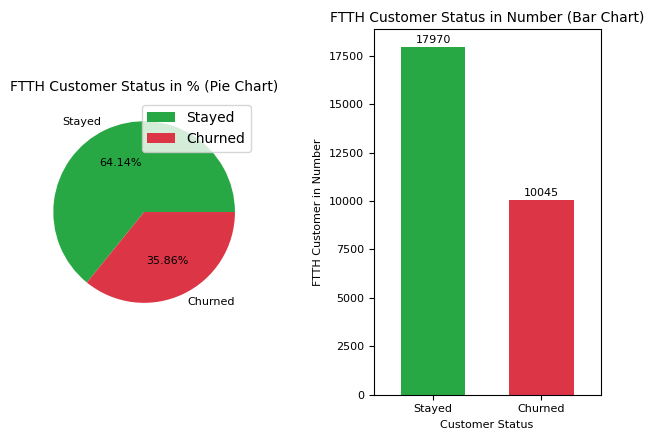

In [36]:
# Display summary of data with pie chart and bar disgram

# Create pie chart
labels = ['Stayed', 'Churned']

# Create a 1x2 grid for the subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4.5))  # Increased width to maintain spacing

# Plot the pie chart in the first subplot (ax1)
training_data['CUSTOMER_STATUS'].value_counts().plot.pie(
    autopct='%.2f%%',
    labels=labels,
    colors=['#28a745', '#dc3545'],
    fontsize=8,
    ax=ax1
)
ax1.set_title('FTTH Customer Status in % (Pie Chart)', fontsize=10)
ax1.legend(labels, loc='upper right')
ax1.set_ylabel('')

# **********************************************************************
# Plot the bar chart in the second subplot (ax2)
ax2 = training_data['CUSTOMER_STATUS'].value_counts().plot.bar(
    color=['#28a745', '#dc3545'],
    width=0.6,
    fontsize=8,
    ax=ax2
)
ax2.set_title('FTTH Customer Status in Number (Bar Chart)', fontsize=10)
ax2.set_ylabel('FTTH Customer in Number', fontsize=8)
ax2.set_xlabel('Customer Status', fontsize=8)

# Set custom labels for the bars
ax2.set_xticklabels(labels, rotation=0)

for i in ax2.patches:
    height = i.get_height()
    ax2.annotate(f'{height}',
                 xy=(i.get_x() + i.get_width() / 2, height),
                 xytext=(0, 3),  # Offset for the text from the bar
                 textcoords="offset points",
                 ha='center',
                 fontsize=8
                )

plt.tight_layout(w_pad=4)  # Adjust horizontal spacing between subplots

plt.show()

### Categorize Dataset Columns

Observations: 28015
Columns: 21
Categorical columns: 15
Numerical columns: 4
Categorical High Cardinality: 2
Numerical High Cardinality: 5


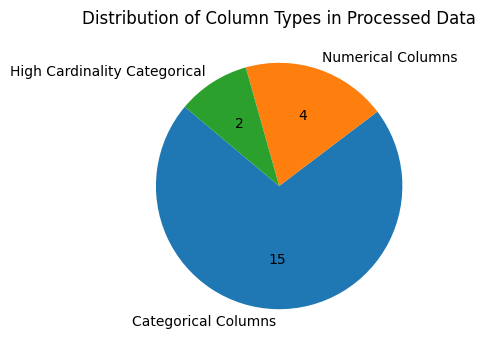

In [37]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Columns: {dataframe.shape[1]}")
    print(f'Categorical columns: {len(cat_cols)}')
    print(f'Numerical columns: {len(num_cols)}')
    print(f'Categorical High Cardinality: {len(cat_but_car)}')
    print(f'Numerical High Cardinality: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(processed_data)

def absolute_value(val):
    a  = round(val/100.*sum(counts))
    return a

# Getting the counts for the pie chart
counts = [len(cat_cols), len(num_cols), len(cat_but_car)]

# Labels for the pie chart
labels = ['Categorical Columns', 'Numerical Columns', 'High Cardinality Categorical']

# Creating the pie chart
plt.figure(figsize=(4, 4))
plt.pie(counts, labels=labels, autopct=absolute_value, startangle=140)
plt.title('Distribution of Column Types in Processed Data')
plt.show()

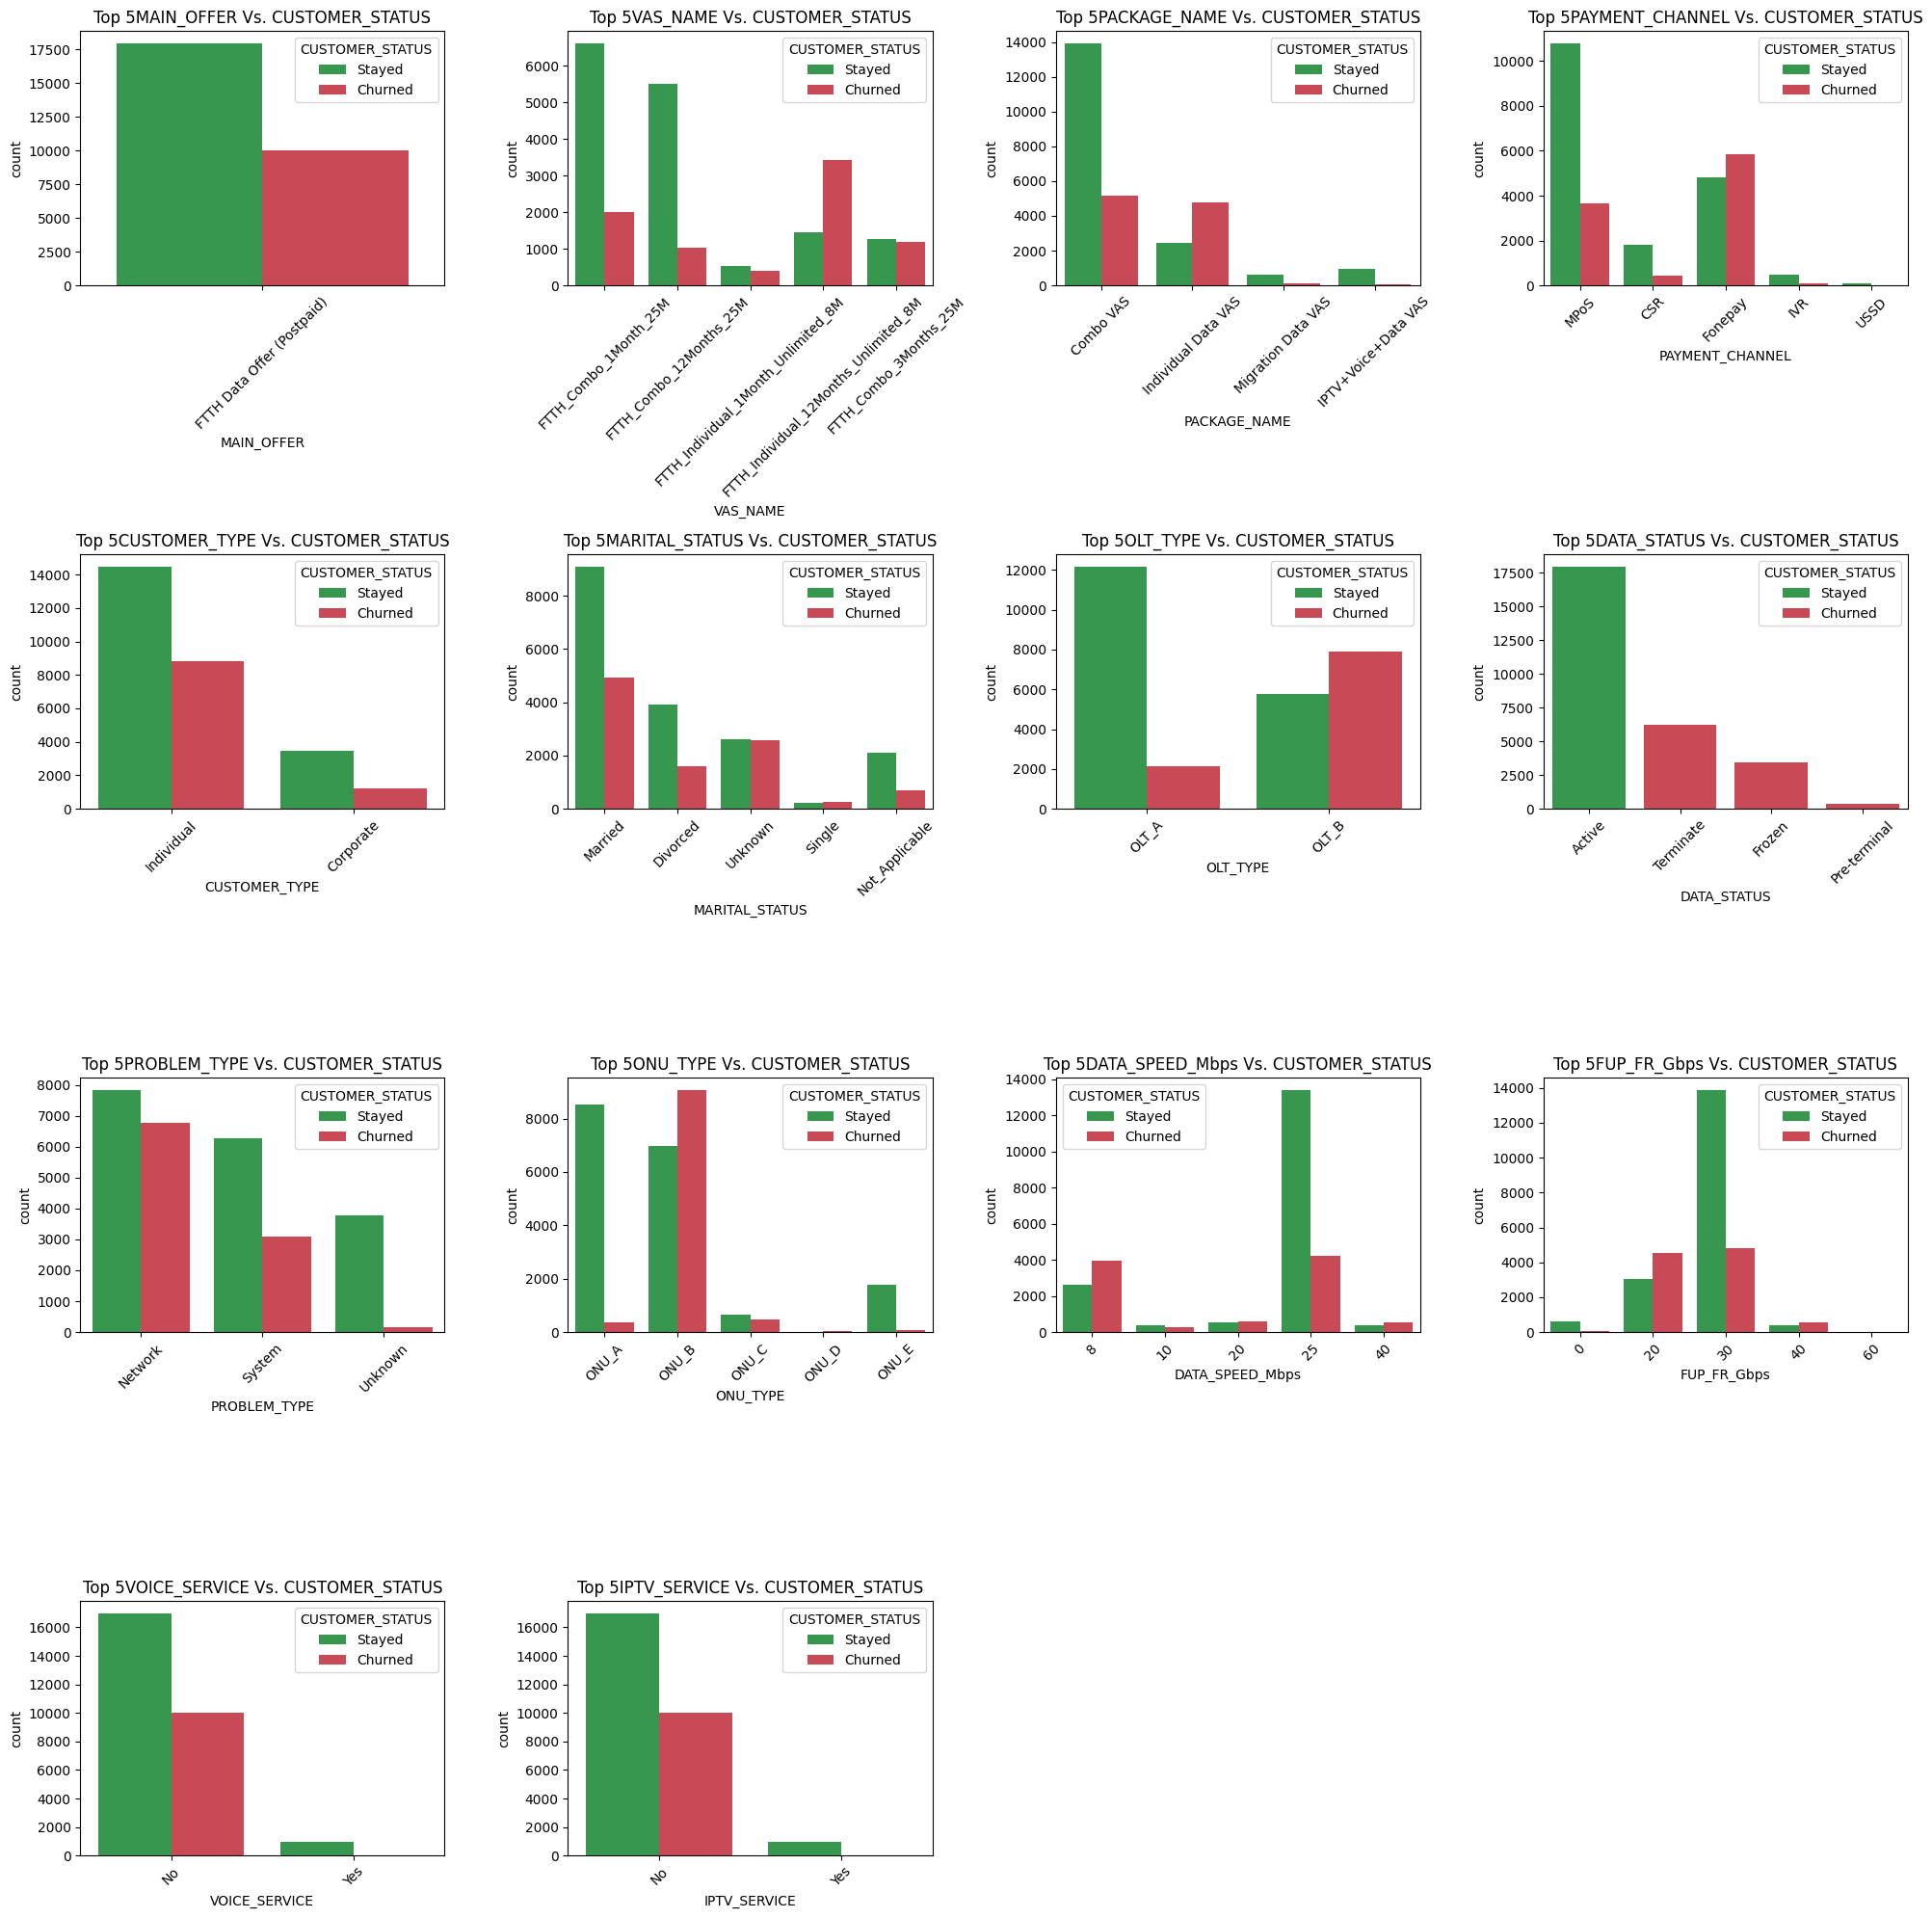

In [38]:


def cat_summary(dataframe, cat_cols, status_col):
        # Determine the number of rows needed for subplots (4 columns per row)
        n_cols = 4
        n_rows = (len(cat_cols) + n_cols - 1) // n_cols  # Calculate rows needed

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
        axs = axs.ravel()  # Flatten the array of axes for easier iteration

        for i, col in enumerate(cat_cols):
                if(col==status_col):
                        continue 
                top_categories = dataframe[col].value_counts().nlargest(5).index
                filtered_data = dataframe[dataframe[col].isin(top_categories)]
                # # Create the countplot on the respective subplot
                sns.countplot(x=col, hue=status_col, data=filtered_data, ax=axs[i],palette=['#28a745', '#dc3545'])
                axs[i].set_title("Top 5"  + col + " Vs. " + status_col)
                axs[i].tick_params(axis='x', rotation=45)
                axs[i].legend(title=status_col)
        while(i<=len(cat_cols)):
                axs[i].axis("off")
                i=i+1

        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()
            
            

status_col = 'CUSTOMER_STATUS'  # Define your status column, e.g., "Stayed" vs "Churned"
cat_summary(training_data, cat_cols, status_col)


/var/folders/5v/rs4ws06j7x78q25f1pxgyzd40000gn/T/ipykernel_61067/2812128181.py:22: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



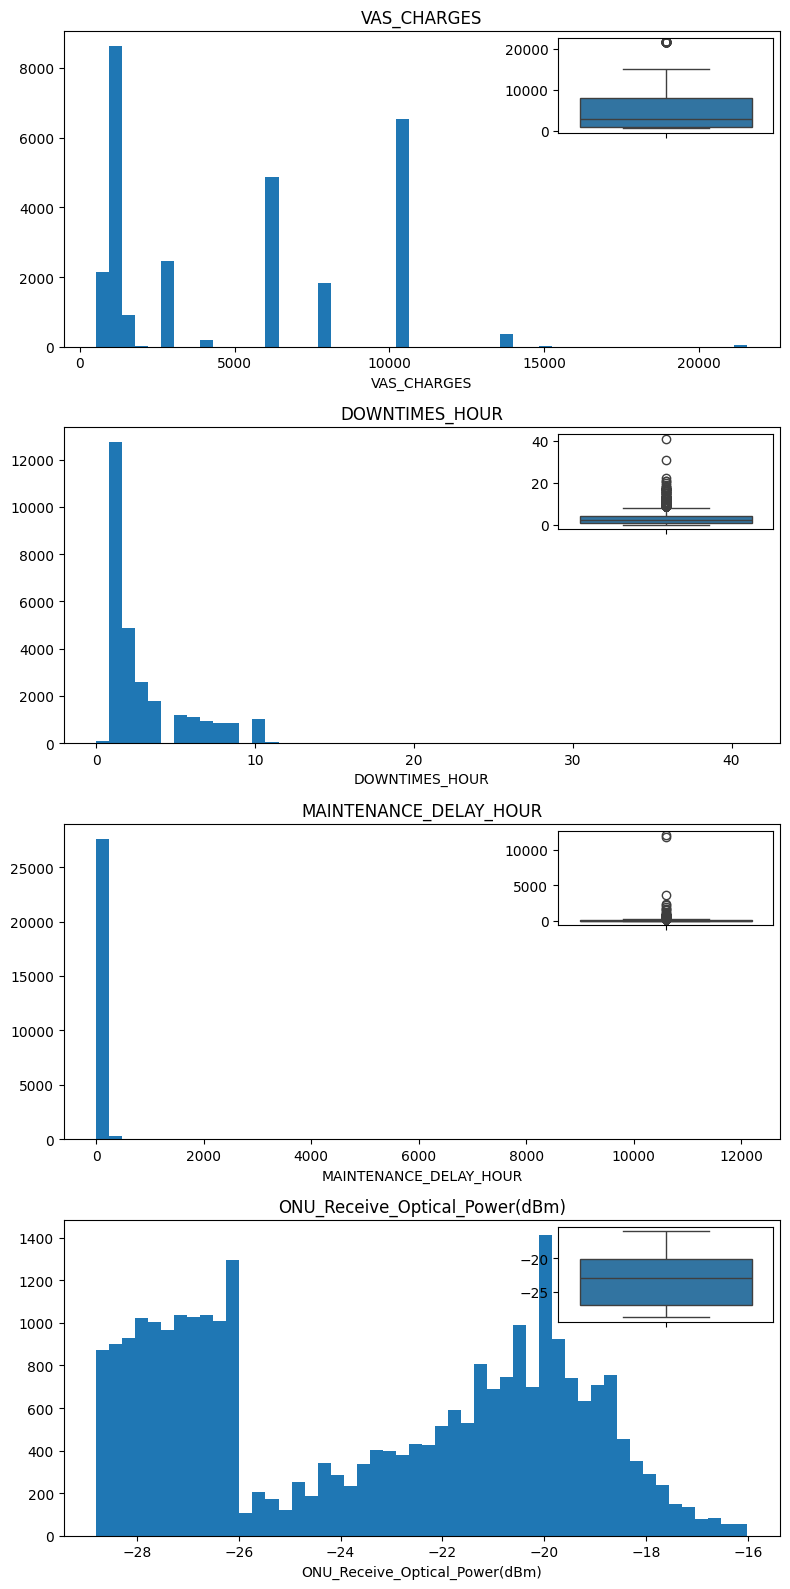

In [39]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def num_summary(dataframe, num_cols, plot=True):
    if plot:
        n_cols = 1  # We only need one column per row since each histogram will contain its boxplot
        n_rows = len(num_cols)  # One row per numerical column

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, n_rows * 4))
        axs = axs.ravel() if n_rows > 1 else [axs]  # Handle the case of a single row

        for i, col in enumerate(num_cols):
            # Create histogram
            axs[i].hist(dataframe[col].dropna(), bins=50)
            axs[i].set_xlabel(col)
            axs[i].set_title(col)

            # Create an inset axes for the boxplot inside the histogram
            ax_inset = inset_axes(axs[i], width="30%", height="30%", loc='upper right')
            sns.boxplot(y=col, data=dataframe, ax=ax_inset)
            ax_inset.set_ylabel('')

        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()


num_summary(training_data, num_cols)

### Data Cleaning and Preprocessing

#### 1. Fill Missing Values
Before applying any machine learning algorithms, it's crucial to ensure that the data is clean and ready. One common issue in datasets is missing values. Depending on the nature of the data and the missing values, different strategies might be used:

- **For numerical data**, common strategies include filling missing values with the mean, median, or mode of the column.
- **For categorical data**, you can fill missing values with the most frequent category, or a new category representing 


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Fill missing values
imputer = SimpleImputer(strategy='mean')
numerical_features = processed_data.select_dtypes(include=['float64', 'int64']).columns
processed_data[numerical_features] = imputer.fit_transform(processed_data[numerical_features])

# Encode categorical features
categorical_features = processed_data.select_dtypes(include=['object']).columns
label_encoders = {column: LabelEncoder() for column in categorical_features}
for column in categorical_features:
    processed_data[column] = label_encoders[column].fit_transform(processed_data[column])

processed_data.head()

,CUSTOMER_ID,MAIN_OFFER,VAS_NAME,PACKAGE_NAME,VAS_CHARGES,DATA_SPEED_Mbps,FUP_FR_Gbps,VOICE_SERVICE,IPTV_SERVICE,PAYMENT_CHANNEL,...,MARITAL_STATUS,AREA_Name,OLT_TYPE,DATA_STATUS,CUSTOMER_STATUS,DOWNTIMES_HOUR,MAINTENANCE_DELAY_HOUR,PROBLEM_TYPE,ONU_TYPE,ONU_Receive_Optical_Power(dBm)
0,7331,0,3,0,981.59,25.0,30.0,0.0,0.0,3,...,1,97,0,0,1.0,1.0,29.0,0,0,-21.368
1,11530,0,0,0,10376.75,25.0,30.0,0.0,0.0,3,...,1,178,1,0,1.0,1.0,87.0,0,1,-22.130
2,7368,0,0,0,10376.75,25.0,30.0,0.0,0.0,0,...,1,89,0,0,1.0,1.0,46.0,0,0,-21.939
3,598,0,0,0,10376.75,25.0,30.0,0.0,0.0,3,...,1,69,1,0,1.0,1.0,4.0,0,2,-21.490
4,2897,0,0,0,10376.75,25.0,30.0,0.0,0.0,3,...,0,23,0,0,1.0,3.0,53.0,1,1,-23.874


### Feature selection
- Drop Unncessary features such as Customer ID, VAS Name, Area, Package , FUP etc which are less relevant to the customer churn
- Use Mutual Information Classifier in identifying the features that are most informative for predicting the target variable, guiding feature selection for model building.

In [43]:
# Step 4: Feature Selection
X = processed_data.drop(columns=['MAIN_OFFER','CUSTOMER_STATUS','CUSTOMER_ID','VAS_NAME','AREA_Name','PACKAGE_NAME','FUP_FR_Gbps'])
y = processed_data['CUSTOMER_STATUS']

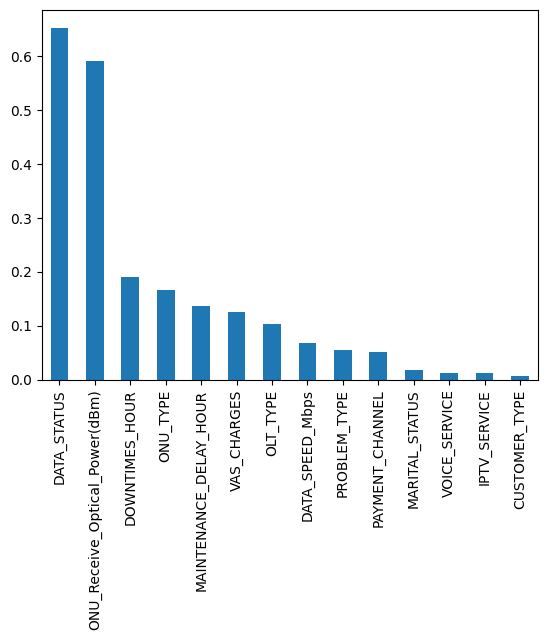

In [44]:
# Using mutual information to select important features
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X, y)
mutual_info = pd.Series(mutual_info, index=X.columns)
mutual_info.sort_values(ascending=False).plot.bar()
plt.show()

### Feature Selection
- From the Mutual Information Classification, `DATA_STATUS` and `Rx level` show high mutual information scores with customer churn. This indicates that they are highly informative for predicting churn but may not be too realistic to give away the target directly


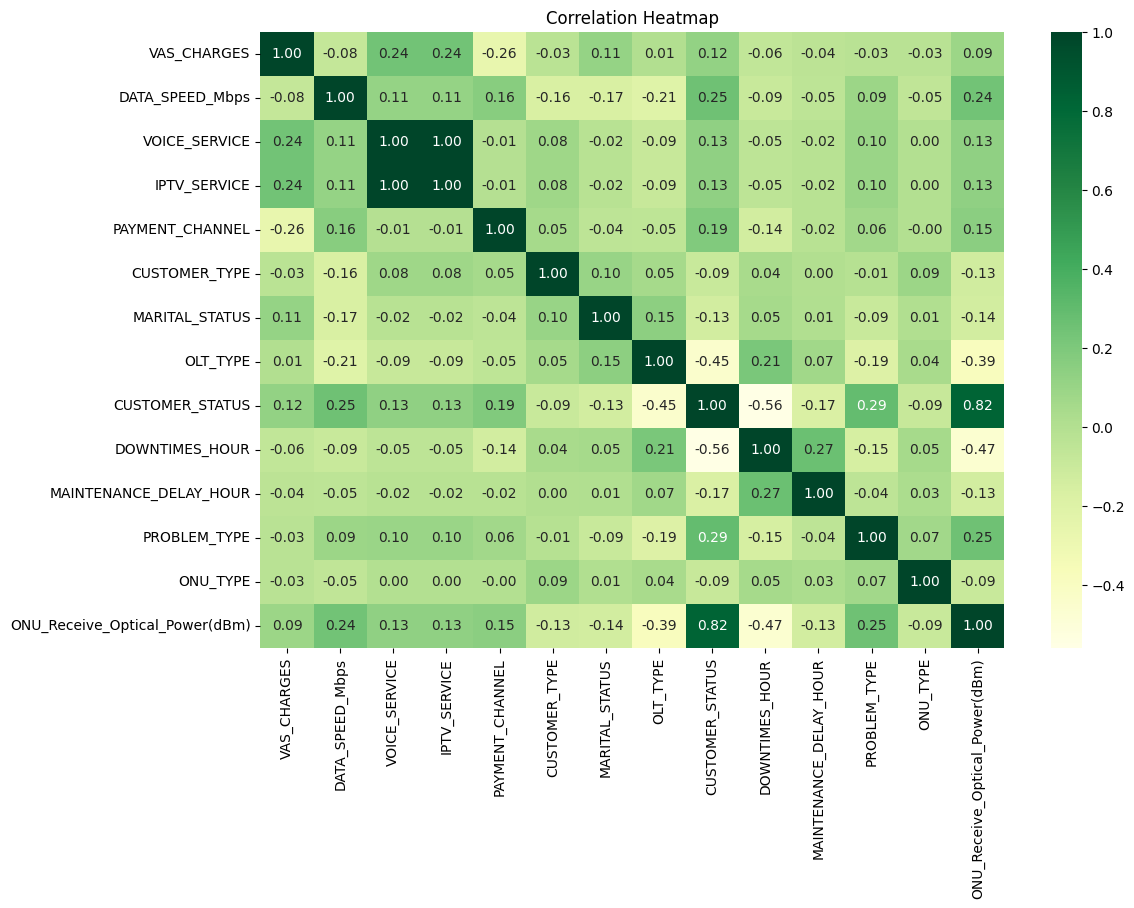

In [45]:
correlation_data=processed_data.drop(columns=['MAIN_OFFER','DATA_STATUS','CUSTOMER_ID','VAS_NAME','AREA_Name','PACKAGE_NAME','FUP_FR_Gbps'])
# Calculate correlation matrix
correlation_matrix = correlation_data.corr()
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGn', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

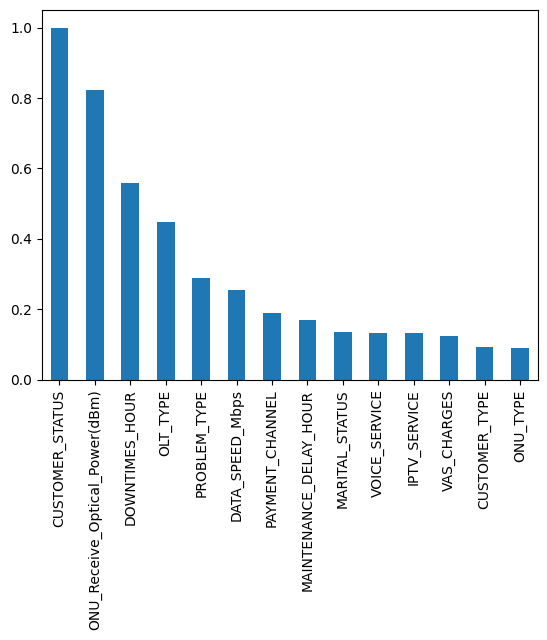

In [46]:
# Assuming correlation_matrix is the correlation matrix between features and the target variable
target_correlation = correlation_matrix['CUSTOMER_STATUS'].abs().sort_values(ascending=False)
target_correlation.plot.bar()
plt.show()

### Process Data for modeling
- Remove the target column from the processed data
- Remove irrelevant columns from the processed data
- Prepare the target data
- Split the training data into 70% and 30% testing

In [47]:
X = processed_data.drop(columns=['MAIN_OFFER','CUSTOMER_STATUS','DATA_STATUS','ONU_Receive_Optical_Power(dBm)','CUSTOMER_ID','VAS_NAME','AREA_Name','PACKAGE_NAME','FUP_FR_Gbps'])
y = processed_data['CUSTOMER_STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Fit the models

In [48]:
# Initialize models
logistic_model = LogisticRegression(max_iter=100000)
tree_model = DecisionTreeClassifier()
forest_model = RandomForestClassifier()
xgb_model = XGBClassifier()
svc_model=SVC(probability=True)

#Prepare the list of the models
models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": forest_model,
    "XGB Classifier": xgb_model,
    "SVC": svc_model
}
# Standardize the features for SVM
sc = StandardScaler()
SVC_train = sc.fit_transform(X_train)
SVC_test = sc.transform(X_test)


/var/folders/5v/rs4ws06j7x78q25f1pxgyzd40000gn/T/ipykernel_61067/4181314374.py:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



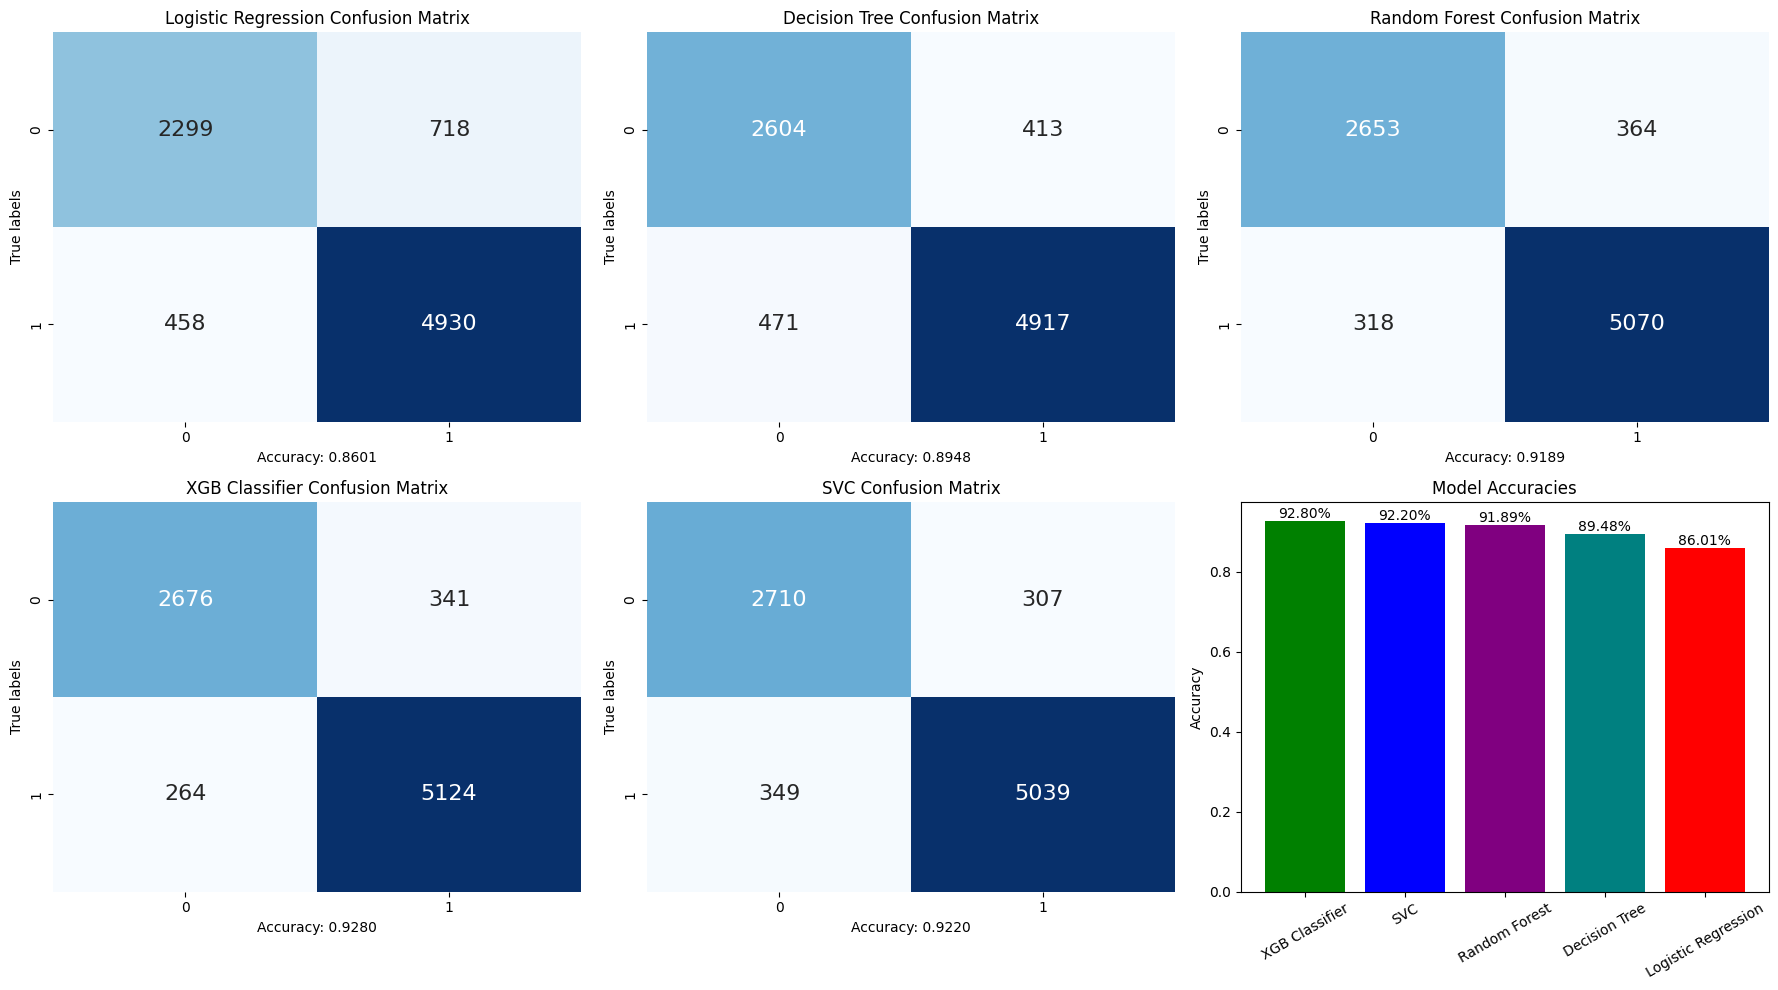

In [49]:
# Plotting setup
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Adjust size as needed
axes = axes.ravel()  # Flatten axes array
model_accuracies={}
for i, (name, model) in enumerate(models.items()):
    if(name=='SVC'):
      model.fit(SVC_train, y_train)
      model_pred=model.predict(SVC_test)
    else:
      model.fit(X_train, y_train)
      model_pred=model.predict(X_test)
    model_acc = accuracy_score(y_test, model_pred)
    model_accuracies[name]=model_acc
    model_cm = confusion_matrix(y_test, model_pred)

     # Plot ROC curve
    ax = axes[i]
    sns.heatmap(model_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,annot_kws={'size': 16})
    ax.set_title(name+ " Confusion Matrix")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xlabel(f"Accuracy: {model_acc:.4f}")
#Get the last axis
ax=axes[i+1]
# Sort the dictionary by values in descending order
sorted_models = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)

# Extract sorted keys and values
sorted_model_names = [model[0] for model in sorted_models]
sorted_accuracies = [model[1] for model in sorted_models]


# Bar chart for accuracies
bars=ax.bar(sorted_model_names, sorted_accuracies, color=['green', 'blue', 'purple','teal','red'])
ax.set_title("Model Accuracies")
ax.set_ylabel('Accuracy')

ax.set_xticklabels(sorted_model_names,rotation=30)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2%}', va='bottom', ha='center')
plt.tight_layout()
plt.show()

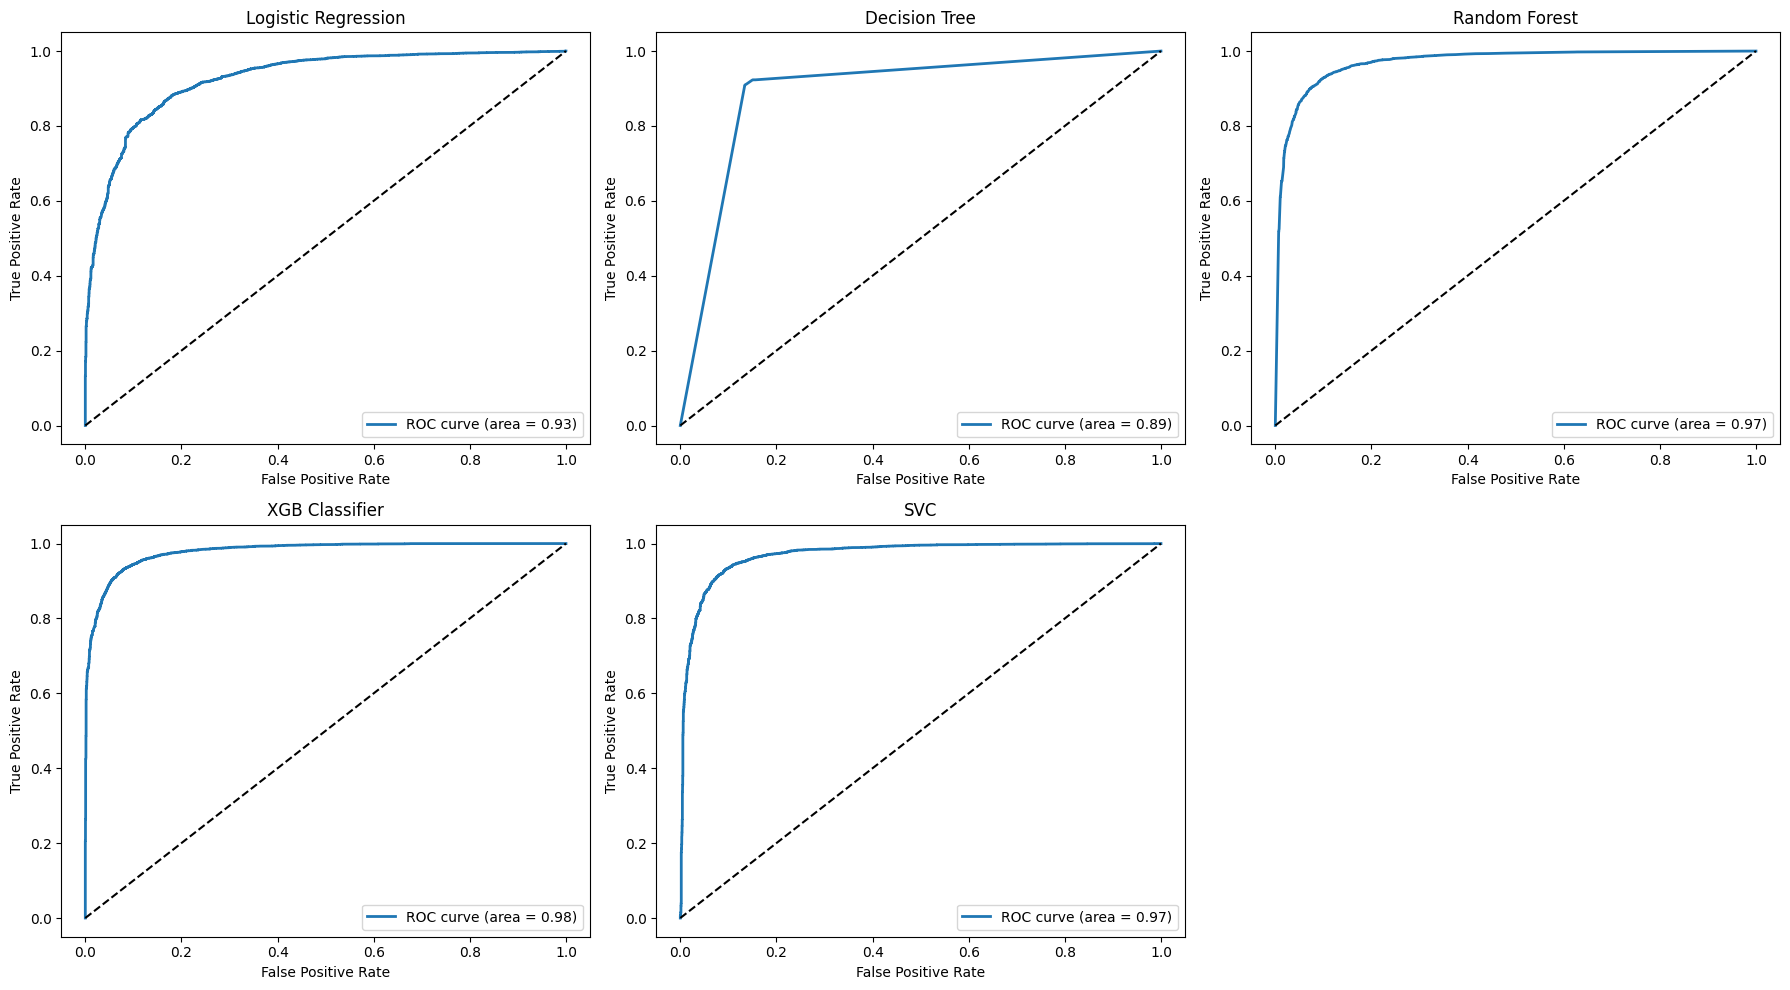

In [19]:

# Plotting setup
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Adjust size as needed
axes = axes.ravel()  # Flatten axes array

for i, (name, model) in enumerate(models.items()):
    if hasattr(model, "predict_proba"):
        if(name=='SVC'):
            probs = model.predict_proba(SVC_test)[:, 1] # Get probability of positive class
        else:
            probs = model.predict_proba(X_test)[:, 1]  

    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    # Plot ROC curve
    ax = axes[i]
    ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    ax.set_title(name)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
axes[i+1].axis('off')

# Adjust subplot spacing
plt.tight_layout()
plt.show()